# Вариант 3:

#### Протокол томографии MUB 20 входных состояний. Размерномть матриц плотности 4.

In [37]:
import numpy as np
import pandas as pd
import copy
from numpy import linalg as LA
from scipy import linalg as sLA
from tqdm import tqdm
from itertools import product
from matplotlib import pyplot as plt

In [2]:
# Массив унитарных матриц образующих MUB для d = 4

mub_array = 1/2*np.array([
    [[2,0,0,0],
     [0,2,0,0],
     [0,0,2,0],
     [0,0,0,2]],
    
    [[1,1,1,1],
     [1,1,-1,-1],
     [1,-1,-1,1],
     [1,-1,1,-1]],
    
    [[1,1,1,1],
     [-1,-1,1,1],
     [-1j,1j,1j,-1j],
     [-1j,1j,-1j,1j]],
    
    [[1,1,1,1],
     [-1j,-1j,1j,1j],
     [-1j,1j,1j,-1j],
     [-1,1,-1,1]],
    
    [[1,1,1,1],
     [-1j,-1j,1j,1j],
     [-1,1,-1,1],
     [-1j,1j,1j,-1j]],
      
])

In [3]:
# Получаем операторы P(j,k) и B из набора матриц, соответствующих заданному MUB 
def build_P(mub_array):
    P = []
    B = []
    for mub in mub_array:
        P_part = []
        B_part = []
        for string in mub.T:
            op = np.outer(string, string.conj())
            P_part.append(op)
            B_part.append(np.ravel(op, order = 'C'))
        B.append(B_part)
        P.append(P_part)
    return np.array(P), np.vstack(np.array(B))

# Получаем операторы X из набора матриц, соответствующих заданному MUB 
def build_X(mub_array):
    X = np.vstack(copy.deepcopy(mub_array).transpose((0,2,1)).conj())
    return X
    

In [38]:
# Составим матрицу B для моделирования процесса измерений состояния
P_list, _ = build_P(mub_array)

In [5]:
# Класс квантового состояния
class State():
    
    def __init__(self, d = 4):
        self.d = d
        self.phi = None
        self.rho = None
        
    def build_clear_state(self, random_state = 42):
        
    
        phi = np.random.randn(int(d)) + 1j*np.random.randn(int(d))
        self.phi = phi/ np.sqrt((sum(abs(phi) ** 2))) #np.sqrt(np.dot(phi, phi.conj()))
        self.rho = np.outer(self.phi, self.phi.conj())
        
    def build_random_state(self, random_state = 42):
        d = self.d
        
        C_list = np.random.normal(0, 1, size=(d, 2)) + 1j*np.random.normal(0, 1, size=(d, 2))
        C_list = C_list/(np.sqrt(np.sum(C_list*np.conjugate(C_list))))
        C_list = np.reshape(C_list, [1,d,2,1])
        g_rho = np.tensordot(C_list, np.conjugate(C_list), [0,3])
        g_rho = np.reshape(g_rho, (d,2,d,2))
        self.rho = np.trace(g_rho, axis1=1, axis2=3)
        
    def set_phi(self, coefs):
        self.phi = coefs
        self.rho = np.outer(self.phi, self.phi.conj())
        
    def get_phi(self):
        return self.phi
    
    def get_rho(self):
        return self.rho
    
        
#Вычисление Фиделити для матриц плотности
def Fidelity(rho1, rho2):
    return np.abs(np.trace(sLA.sqrtm(sLA.sqrtm(rho1) @ rho2 @ sLA.sqrtm(rho1))))**2       

#Вычисление Фиделити для векторов чистых состояний
def Fidelity_pure(vec0, vec1):
    return np.abs(np.dot(vec0, vec1.conjugate())) ** 2

#Вычисление\норму Фробениуса
def Frobenius_norm(matrix):
    return np.sqrt(np.sum(list(map(lambda x: np.abs(x) ** 2,matrix))))

In [6]:
# Задаёт случайный процесс
def gen_U(d = 4):
    u = np.reshape(np.random.randn(d**2) + 1j*np.random.randn(d**2), (d, d))
    return LA.qr(u)[0]

# Очищение матрицы плотности до вектора чистого состояния
def purify_rho_to_psi(rho, rang = 1):
    
    
    vals, vecs = LA.eig(rho.copy())
    
    
    indices = vals.argsort()
    vals_pure = vals[sorted(indices[-rang:])]
    vecs_pure = vecs.T[sorted(indices[-rang:])].T
    

    psi = np.dot(vecs_pure, np.diag(np.sqrt(vals_pure)))
    
    return psi

In [7]:
# Моделирует серию измерений:
def estimate_probs(rho, B, n_shots = 100):
    p_B = abs(np.dot(B, np.ravel(rho, order = 'F')))
    samples = [np.random.binomial(n_shots, p_B[i]) for i in range(p_B.shape[0])]
    return np.array(samples)/n_shots


# Корректирует СЗ восстановленной матрицы, проектируя её на 
# множество матриц плотности
def correct_eigvals(v):
    
    vals = sorted(v)[::-1]
    inds = np.arange(len(vals))
    w_list = np.abs(np.cumsum(vals)-1)/(inds + 1)
    
    j = 0
    for val, w in zip(vals,w_list):
        if (val - w) <0:
            break
        else:
            j += 1
        
    vals_correct = copy.deepcopy(v)
    
    if  j <= (len(vals) - 1):
        vals_correct = vals_correct - w_list[j-1]
        vals_correct[vals_correct<0] = 0
        
    return vals_correct

def project_rho(rho):
    
    vals, vecs = LA.eig(rho.copy())
    vals_new = correct_eigvals(vals)
    psi = np.dot(vecs, np.diag(np.sqrt(vals_new)))
    rho_new = np.dot(psi, psi.conj().T)
    return rho_new
    
    


# реализут восстановление матрицы плотности
def recover_rho(B, probs, correct_rho = True):
    u, s, vh = LA.linalg.svd(B)
    q = np.dot(u.conj().T, probs)
    
    tail_num = B.shape[0] - B.shape[1]
    f = q[:-tail_num]/s
    rho_new = np.reshape(np.dot(vh.conj().T, f),(int(np.sqrt(vh.shape[0])),int(np.sqrt(vh.shape[0])))).conj()
    
    vals, vecs = LA.eig(rho_new)
    
    delta = np.abs(np.sum(vals[vals<0]))
    
    rho_new_correct = rho_new.copy()
    
    if correct_rho == True:
        vals_new = correct_eigvals(vals)
        rho_new_correct = vecs @ np.diag(vals_new) @ vecs.conj().T
        
    return rho_new_correct, delta

In [42]:
def psi_prob(psi, P_matrix):
    prob = np.trace(psi @ psi.conj().T @ P_matrix)
    return prob

def J_operator(psi, k_list, P_list):
    prob_list = np.array([psi_prob(psi, P_matrix) for P_matrix in P_list])
    J = np.sum((P_list.T*k_list/prob_list).T, axis = 0)
    return J

def update_psi(psi, k_list, P_list, mu = 0.5, n_list = None, I_inv = None):
    psi_new = (1 - mu)*I_inv@J_operator(psi, k_list, P_list)@psi.copy() + mu*psi.copy()
    return psi_new

def find_MML_psi(rho, k_list, P_list, mu = 0.5, eps = 1e-8, n_list = None, verbose = False, I_inv = None):
    psi = purify_rho_to_psi(rho, rang = 1)
    for i in range(5000):
        psi_new = update_psi(psi.copy(), k_list, P_list, mu = mu, n_list = n_list, I_inv = I_inv)
        err = abs(Frobenius_norm(psi @ psi.T.conj() - psi_new @ psi_new.T.conj()))
        if verbose:
            print(err)
        if err < eps:
            break
        psi = psi_new
    return psi @ np.conj(psi.T)
        

#### Зададим 20 случайных состояний

In [23]:
state = State(4)
M = 20 # колличество состояний

input_states = []
lambdas = []
B = []
for i in range(M):
    state.build_random_state()
    rho = state.get_rho()
    input_states.append(rho)

In [25]:
P_list.shape

(5, 4, 4, 4)

In [27]:
n = 100 

# Создадим эффективные операторы измерения
lambdas = [np.kron(i_state.conj(), P)
           for i_state, P in product(input_states, np.reshape(P_list, (20,4,4)))]

# Создадим фиктивные операторы измерения для сохранения следа
lambdas_fictive = [np.kron(P, np.eye(4)) for P in np.reshape(P_list, (20,4,4))]

# Дополним ими эффективные операторы измерения
lambdas_all = lambdas + lambdas_fictive

# Измерения фиктивных операторов 1000 * 100 измерений на каждый с вероятностью 1
samples_fictive = [1000*n]*np.shape(lambdas_fictive)[0]

# Измерения 'эффективных операторов 100 измерений на каждый
n_list_small = [n]*np.shape(lambdas)[0]

# Объединим в один массив
n_list = np.array(n_list_small + samples_fictive)

I = np.sum([n_list[i] * lambdas_all[i] for i in range(n_list.shape[0])], axis=0)
I_inv = LA.inv(I)

In [31]:
# Составим из списков операторов Lambda матрицу B (для случая с добавлением фиктивных операторов и без)
B = np.reshape(np.array([[np.ravel(l, order = 'C') for l in l_part_list] for l_part_list in lambdas_all]), (420, 16*16))
B_small = np.reshape(np.array([[np.ravel(l, order = 'C') for l in l_part_list] for l_part_list in lambdas]), (400, 16*16))

In [32]:
print(f'Число обусловленности B c фиктивными измерениями: {LA.cond(B)}')
print(f'Число обусловленности B БЕЗ фиктивнх измерений: {LA.cond(B_small)}')

Число обусловленности B c фиктивными измерениями: 45.50642642451423
Число обусловленности B БЕЗ фиктивнх измерений: 35.3937834173149


Число обусловленности матрицы B большое, что говорит о низком ранге матрицы B. Вероятно это указывает на информационную полноту системы эффективных измерений Лямбда (по аналогии с переопределённой системой уравнений).

In [33]:
B.shape

(420, 256)

In [43]:
num_proc = 100
d = 4

F_list = []
F_MML_list = []

for i in tqdm(range(num_proc)):
    
    U = gen_U(d = 4)
    e = np.reshape(U, np.prod(U.shape))
    chi = np.outer(e, np.conj(e))
    probs = estimate_probs(chi, B_small, n_shots = 100)
    
    samples_all = list(n*probs) + samples_fictive
    probs_all = np.array(list(probs) + [1]*len(samples_fictive))
    
    rho_rec, _ = recover_rho(B, probs_all, correct_rho = True)
    rho_rec = project_rho(rho_rec)
    

    rho_MML = find_MML_psi(rho_rec, samples_all, np.array(lambdas_all), mu = 0.5,
                           eps = 1e-8, n_list = n_list,I_inv = I_inv, verbose = False)
    rho_MML = project_rho(rho_MML)
    
    
    F_list.append(Fidelity(rho_rec, chi/d))
    F_MML_list.append(Fidelity(rho_MML, chi/d))

    

100%|██████████| 100/100 [1:09:18<00:00, 41.58s/it]


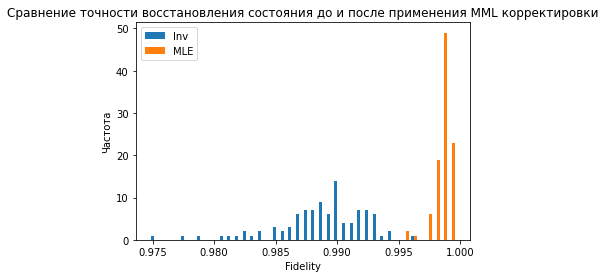

In [47]:
plt.hist([F_list, F_MML_list], bins=40, label=['Inv','MLE'])
plt.legend()
plt.title('Сравнение точности восстановления состояния до и после применения MML корректировки')
plt.xlabel('Fidelity')
plt.ylabel('Частота')
plt.show()

Гистограмма демонстрирует успешное восстановление состояния